## HW4 (a) Overview (30 points + bonus)

This assignment explores the phonetic and acoustic information is captured at different layers of the Hubert model through **probing experiments**. We'll train simple classifiers and regressors to predict various targets from Hubert features:

1. **Phoneme Recognition**: Train a classifier to predict phone labels from Hubert features
2. **MFCC Regression**: Train a regressor to predict MFCC features from Hubert features  
3. **Speaker Embedding**: Analyze speaker separation in Hubert features using t-SNE
4. **Bonus question** - Create your own speaker embedding

Note - You should use a GPU for this part as well.

## What is Probing?

**Probing** is an interpretability technique to understand what information is encoded in different layers of a neural network. We train simple models (probes) to predict specific targets from the network's internal representations. If a probe can successfully predict a target, it suggests that information is encoded in those representations. Note that when training probes, the aim is to not maximize on accuracy but reflect the true information content in features, and hence you should not overparameterize your classifier.

**Key Questions**:
- What phonetic information is captured at each layer?
- How does the model's understanding evolve from acoustic to phonetics through the layers?
- Can we identify speaker-specific patterns in the features?

## Submission

1. Please submit a PDF of the completed notebook with all outputs.
2. Additionally, submit  a PDF REPORT with the plots and deliverables (including answers to the questions).

NOTE - Only the pdf report will be graded, although we may look at the notebook to verify solutions.

### Task 1: Phoneme Recognition (Classification) [10 Points]

**Objective**: Train a classifier to predict phone labels from Hubert features. This tests how well each layer captures **phonetic information**.

**Task Overview**: In this task, you will implement a phoneme recognition probe to understand how phonetic information is encoded across different layers of the Hubert model. You'll load pre-computed Hubert features and corresponding phone labels for each layer (0-12), then train a simple 2-layer neural network classifier to predict phone categories from these features. Your goal is to investigate whether different layers of the model contain varying amounts of phonetic information, and if so, how this information is distributed across the model's depth.

In [4]:
import os
import json
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, r2_score
import pandas as pd
from pathlib import Path
import warnings
from google.colab import drive
import zipfile
warnings.filterwarnings('ignore')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

drive.mount('/content/drive')
DATA_DIR = "/content/drive/MyDrive/183/183dataset"

Using device: cuda
Mounted at /content/drive


In [18]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)


Using device: cuda


**Download phoneme recognition data using the link below**
https://drive.google.com/file/d/1UuABo6aDByR61DPcESzc6jm5aMAAOM2Y/view?usp=sharing

**Setting up data and Mounting Drive**
To avoid loosing your data as collab runtime disconnects, you should mount your google drive here so that you are able to use the same data folder. An example of how to mount drive is given in the hw4 part b notebook.


In [4]:
# Mounting your Google drive to Colab environment.
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')
print("mounted")

data_zip = '/content/drive/MyDrive/183/phoneme_layer_datasets.zip'

import zipfile

with zipfile.ZipFile(data_zip, 'r') as zip_ref:
    zip_ref.extractall('/content/drive/MyDrive/183/183dataset/')

print("extracted")
DATA_DIR = "/content/drive/MyDrive/183/183dataset"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
mounted
extracted


In [5]:
def load_phoneme_data(base_folder, layer_idx):
    """
    Helper function to load phoneme data for a specific layer.
    This function loads the features and labels for a specific layer from the base folder.
    The features are loaded as PyTorch tensors and the labels are loaded as JSON files.
    The labels are already string phone names.
    Use this function to load the data for a specific layer.
    We recommend you to play around with the loaded data to understand the format and the information contained.
    """
    base_path = os.path.join(base_folder, f"layer_{layer_idx}")

    # Load features (PyTorch tensors)
    train_features = torch.load(os.path.join(base_path, 'train_features.pt'))
    dev_features = torch.load(os.path.join(base_path, 'dev_features.pt'))
    test_features = torch.load(os.path.join(base_path, 'test_features.pt'))

    # Load labels (JSON files with 'labels' key)
    with open(os.path.join(base_path, 'train_labels.json'), 'r') as f:
        train_labels_data = json.load(f)
    with open(os.path.join(base_path, 'dev_labels.json'), 'r') as f:
        dev_labels_data = json.load(f)
    with open(os.path.join(base_path, 'test_labels.json'), 'r') as f:
        test_labels_data = json.load(f)

    # Extract labels from JSON structure (labels are already string phone names)
    train_labels = train_labels_data['labels']
    dev_labels = dev_labels_data['labels']
    test_labels = test_labels_data['labels']

    # Create vocabulary from all unique labels in the dataset
    all_labels = train_labels + dev_labels + test_labels
    unique_labels = sorted(list(set(all_labels)))
    phone_vocab = {label: idx for idx, label in enumerate(unique_labels)}

    print(f"Created vocabulary with {len(unique_labels)} unique phone classes:")
    print(f"Sample phones: {unique_labels[:10]}")

    # Convert string phone labels to integer indices using our vocabulary
    train_labels = [phone_vocab[label] for label in train_labels]
    dev_labels = [phone_vocab[label] for label in dev_labels]
    test_labels = [phone_vocab[label] for label in test_labels]

    # Convert to PyTorch tensors
    train_labels = torch.tensor(train_labels, dtype=torch.long)
    dev_labels = torch.tensor(dev_labels, dtype=torch.long)
    test_labels = torch.tensor(test_labels, dtype=torch.long)

    return train_features, train_labels, dev_features, dev_labels, test_features, test_labels

# Test loading data for layer 0
base_folder = "/content/drive/MyDrive/183/183dataset/phoneme_layer_datasets"
layer_idx = 0
train_features, train_labels, dev_features, dev_labels, test_features, test_labels = load_phoneme_data(base_folder, layer_idx)

print(f"Layer {layer_idx} data loaded successfully!")
print(f"Train features shape: {train_features.shape}")
print(f"Train labels shape: {train_labels.shape}")
print(f"Dev features shape: {dev_features.shape}")
print(f"Test features shape: {test_features.shape}")
print(f"Number of unique phone classes: {len(torch.unique(train_labels))}")

"""
Recommended : Play around with the loaded data to understand the information contained in it.
TODO : Figure out the feature dimensionality based on the loaded data. From that, try to figure out which version of Hubert (HuBERT Base?) is being used.
"""


Created vocabulary with 72 unique phone classes:
Sample phones: ['AA0', 'AA1', 'AA2', 'AE0', 'AE1', 'AE2', 'AH0', 'AH1', 'AH2', 'AO0']
Layer 0 data loaded successfully!
Train features shape: torch.Size([349544, 768])
Train labels shape: torch.Size([349544])
Dev features shape: torch.Size([34171, 768])
Test features shape: torch.Size([34374, 768])
Number of unique phone classes: 72


'\nRecommended : Play around with the loaded data to understand the information contained in it.\nTODO : Figure out the feature dimensionality based on the loaded data. From that, try to figure out which version of Hubert is being used.\n'

In [6]:
class Probe(nn.Module):
    """Generic 2-layer probe for both classification and regression tasks.
    Make sure to use the same architecture for both classification and regression tasks.
    The architecture should have 2 layers, with intermediate hidden dimension of 128.
    The output layer should have the same dimension as the number of classes in the dataset.
    In between the two layers, use a ReLU activation function.

    Note : Follow the above architecture detail exactly. Do not try to overparameterize the probe.
            You are not graded on the accuracy of the probe but on the interpretability of the results.
    """

    def __init__(self, input_dim=768, hidden_dim=128, output_dim=50,):
        super(Probe, self).__init__()

        # Same 2-layer architecture for both classification and regression
        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.network(x)

In [7]:
def train_phoneme_probe(base_folder, layer_idx, num_epochs=10, batch_size=512, learning_rate=0.001):
    """Train phoneme probe for a specific layer."""
    print(f"\n{'='*60}")
    print(f"Training Phoneme Probe for Layer {layer_idx}")
    print(f"{'='*60}")

    # Load data
    train_features, train_labels, dev_features, dev_labels, test_features, test_labels = load_phoneme_data(base_folder, layer_idx)

    # Get number of classes
    num_classes = len(torch.unique(train_labels))
    print(f"Number of phone classes: {num_classes}")
    print(f"Training samples: {len(train_features)}")
    print(f"Dev samples: {len(dev_features)}")
    print(f"Test samples: {len(test_features)}")

    # Standardize features
    train_mean = train_features.mean(dim=0, keepdim=True)
    train_std = train_features.std(dim=0, keepdim=True)

    train_features = (train_features - train_mean) / (train_std + 1e-8)
    dev_features = (dev_features - train_mean) / (train_std + 1e-8)
    test_features = (test_features - train_mean) / (train_std + 1e-8)

    # Move to device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    train_features = train_features.to(device)
    train_labels = train_labels.to(device)
    dev_features = dev_features.to(device)
    dev_labels = dev_labels.to(device)
    test_features = test_features.to(device)
    test_labels = test_labels.to(device)

    # Create model
    model = Probe(input_dim=768, hidden_dim=128, output_dim=num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Create data loaders
    train_dataset = TensorDataset(train_features, train_labels)
    dev_dataset = TensorDataset(dev_features, dev_labels)
    test_dataset = TensorDataset(test_features, test_labels)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Training loop
    best_dev_acc = 0.0
    best_model_state = None

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for batch_features, batch_labels in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_features)
            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * batch_features.size(0)
            _, predicted = torch.max(outputs, 1)
            train_correct += (predicted == batch_labels).sum().item()
            train_total += batch_labels.size(0)

        train_loss /= train_total
        train_acc = train_correct / train_total

        # Dev evaluation
        model.eval()
        dev_correct = 0
        dev_total = 0

        with torch.no_grad():
            for batch_features, batch_labels in dev_loader:
                outputs = model(batch_features)
                _, predicted = torch.max(outputs, 1)
                dev_correct += (predicted == batch_labels).sum().item()
                dev_total += batch_labels.size(0)

        dev_acc = dev_correct / dev_total

        # Save best model
        if dev_acc > best_dev_acc:
            best_dev_acc = dev_acc
            best_model_state = model.state_dict().copy()

        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Dev Acc: {dev_acc:.4f}")

    # Load best model
    model.load_state_dict(best_model_state)

    # Test evaluation
    model.eval()
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for batch_features, batch_labels in test_loader:
            outputs = model(batch_features)
            _, predicted = torch.max(outputs, 1)
            test_correct += (predicted == batch_labels).sum().item()
            test_total += batch_labels.size(0)

    test_acc = test_correct / test_total

    print(f"\nBest Dev Accuracy: {best_dev_acc:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"{'='*60}\n")

    return test_acc

Training phoneme probes for all layers (0-12)...

Training Layer 0...

Training Phoneme Probe for Layer 0
Created vocabulary with 72 unique phone classes:
Sample phones: ['AA0', 'AA1', 'AA2', 'AE0', 'AE1', 'AE2', 'AH0', 'AH1', 'AH2', 'AO0']
Number of phone classes: 72
Training samples: 349544
Dev samples: 34171
Test samples: 34374
Using device: cuda
Epoch 1/5 - Train Loss: 1.5063, Train Acc: 0.5728, Dev Acc: 0.6019
Epoch 2/5 - Train Loss: 1.1899, Train Acc: 0.6455, Dev Acc: 0.6211
Epoch 3/5 - Train Loss: 1.1120, Train Acc: 0.6667, Dev Acc: 0.6277
Epoch 4/5 - Train Loss: 1.0667, Train Acc: 0.6773, Dev Acc: 0.6321
Epoch 5/5 - Train Loss: 1.0353, Train Acc: 0.6864, Dev Acc: 0.6357

Best Dev Accuracy: 0.6357
Test Accuracy: 0.6366


Training Layer 1...

Training Phoneme Probe for Layer 1
Created vocabulary with 72 unique phone classes:
Sample phones: ['AA0', 'AA1', 'AA2', 'AE0', 'AE1', 'AE2', 'AH0', 'AH1', 'AH2', 'AO0']
Number of phone classes: 72
Training samples: 349533
Dev samples: 34187

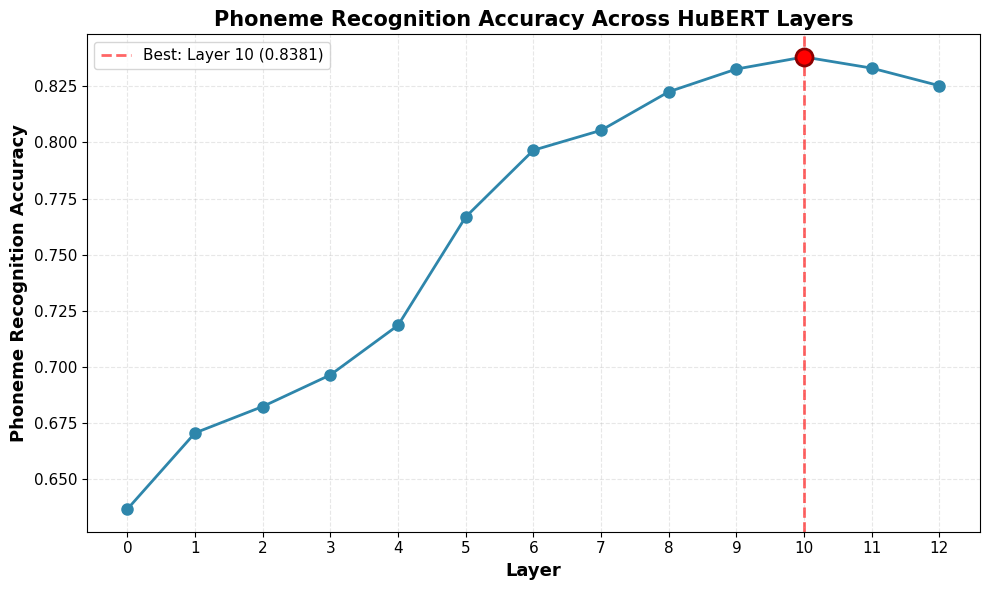


Plot saved as 'phoneme_accuracy_by_layer.png'


In [10]:
### Task 1 : Training the probes
## This code represents an example how the probes are trained.
## You can use this as a reference to train your probes, plot the results.
## You don't have to follow this exact code. Please feel free to modify as per your implementation of the train_phoneme_probe function.
# Note: matplotlib code generated with Claude!

base_folder = "/content/drive/MyDrive/183/183dataset/phoneme_layer_datasets"
num_epochs = 5
batch_size = 512

# Store results for all layers
all_results = []

print("Training phoneme probes for all layers (0-12)...")
print("=" * 60)

for layer_idx in range(13):
    print(f"\nTraining Layer {layer_idx}...")
    test_acc = train_phoneme_probe(base_folder, layer_idx, num_epochs, batch_size)
    all_results.append({'layer': layer_idx, 'test_acc': test_acc})

print(f"\n{'='*60}")
print("TRAINING COMPLETED FOR ALL LAYERS")
print(f"{'='*60}")

# Print test accuracy for each layer
print("\nTest Accuracy by Layer:")
print("-" * 30)
for result in all_results:
    layer = result['layer']
    test_acc = result['test_acc']
    print(f"Layer {layer:2d}: {test_acc:.4f}")

best_result = max(all_results, key=lambda x: x['test_acc'])
print(f"\nBest performing layer: {best_result['layer']}")
print(f"Best test accuracy: {best_result['test_acc']:.4f}")

# Create the plot
plt.figure(figsize=(10, 6))
layers = [result['layer'] for result in all_results]
accuracies = [result['test_acc'] for result in all_results]

plt.plot(layers, accuracies, marker='o', linewidth=2, markersize=8, color='#2E86AB')
plt.xlabel('Layer', fontsize=13, fontweight='bold')
plt.ylabel('Phoneme Recognition Accuracy', fontsize=13, fontweight='bold')
plt.title('Phoneme Recognition Accuracy Across HuBERT Layers', fontsize=15, fontweight='bold')
plt.grid(True, alpha=0.3, linestyle='--')
plt.xticks(layers, fontsize=11)
plt.yticks(fontsize=11)

# Highlight best layer
best_layer = best_result['layer']
best_acc = best_result['test_acc']
plt.axvline(x=best_layer, color='red', linestyle='--', alpha=0.6, linewidth=2,
            label=f'Best: Layer {best_layer} ({best_acc:.4f})')
plt.scatter([best_layer], [best_acc], color='red', s=150, zorder=5, edgecolors='darkred', linewidth=2)

plt.legend(fontsize=11, loc='best')
plt.tight_layout()
plt.savefig('phoneme_accuracy_by_layer.png', dpi=300, bbox_inches='tight')
plt.show()

### Task 1: Deliverables

1. Plot of phoneme recognition accuracy on y-axis vs layers (5 points)

2. Answer the following questions:
    
    2.1 The features used in this task belongs to which version of the Hubert model ? (1 point)

    2.2 What layer features does best in the phoneme recognition task? (1 point)

    2.3 What does this plot show about how phonetic information is captured by Hubert? Why do you think that's the case? (3 points)


### Task 2: MFCC Regression [10 points]

**Objective**: Train a regressor to predict MFCC features from Hubert features. This tests how well each layer captures **acoustic information**.

**What are MFCC Features?**

**MFCC (Mel-Frequency Cepstral Coefficients)** are acoustic features that capture the spectral characteristics of speech. MFCCs are computed by:
1. **Windowing** the audio signal into short frames (typically 25ms)
2. **Computing FFT** to get frequency spectrum
3. **Mel-scale filtering** to simulate human auditory perception
4. **Log transformation** to compress dynamic range
5. **DCT (Discrete Cosine Transform)** to decorrelate coefficients

The 13 MFCC coefficients capture different aspects of the acoustic signal, with lower coefficients representing broader spectral characteristics and higher coefficients capturing finer details.

**Task Overview**: In this task, you will implement an **MFCC regression probe** to understand how acoustic information is encoded across different layers of the Hubert model. You'll load pre-computed Hubert features and corresponding MFCC labels for each layer (0-12), then train a regression probe using the previously defined probe to predict 13 MFCC coefficients from these features. Your goal is to investigate whether different layers of the model contain varying amounts of acoustic information, and if so, how this information is distributed across the model's depth. You'll train separate regressors for each of the 13 layers, evaluate them on held-out test sets using R² scores, and analyze the results to understand what Hubert has learned about acoustic properties at each stage of processing.

**Download mfcc dataset using this link**
https://drive.google.com/file/d/12ikp8GxiU7Ul3i5fR-9Sz2YMt9Jdshv4/view?usp=sharing

In [11]:
data_zip = '/content/drive/MyDrive/183/mfcc_layer_datasets.zip'

with zipfile.ZipFile(data_zip, 'r') as zip_ref:
    zip_ref.extractall('/content/drive/MyDrive/183/mfcc_dataset/')

print("extracted")
mfcc_base_folder = "/content/drive/MyDrive/183/mfcc_dataset"

extracted


In [14]:
def load_mfcc_data(base_folder, layer_idx):
    """Load MFCC data for a specific layer."""
    base_path = os.path.join(base_folder, f"layer_{layer_idx}")

    # Load features (PyTorch tensors)
    train_features = torch.load(os.path.join(base_path, 'train_features.pt'))
    dev_features = torch.load(os.path.join(base_path, 'dev_features.pt'))
    test_features = torch.load(os.path.join(base_path, 'test_features.pt'))

    # Load MFCC labels (JSON files with 'mfcc' key)
    with open(os.path.join(base_path, 'train_mfcc_labels.json'), 'r') as f:
        train_labels_data = json.load(f)
    with open(os.path.join(base_path, 'dev_mfcc_labels.json'), 'r') as f:
        dev_labels_data = json.load(f)
    with open(os.path.join(base_path, 'test_mfcc_labels.json'), 'r') as f:
        test_labels_data = json.load(f)

    # Extract MFCC labels from JSON structure (labels are 13-element lists)
    train_mfcc_labels = train_labels_data['mfcc']  # List of 13-element lists
    dev_mfcc_labels = dev_labels_data['mfcc']
    test_mfcc_labels = test_labels_data['mfcc']

    # Convert to PyTorch tensors (shape: [n_frames, 13])
    train_labels = torch.tensor(train_mfcc_labels, dtype=torch.float32)
    dev_labels = torch.tensor(dev_mfcc_labels, dtype=torch.float32)
    test_labels = torch.tensor(test_mfcc_labels, dtype=torch.float32)

    return train_features, train_labels, dev_features, dev_labels, test_features, test_labels

# Test loading MFCC data for layer 0
mfcc_base_folder = "/content/drive/MyDrive/183/mfcc_dataset/mfcc_layer_datasets"
layer_idx = 0
train_features, train_labels, dev_features, dev_labels, test_features, test_labels = load_mfcc_data(mfcc_base_folder, layer_idx)

print(f"MFCC data loaded for layer {layer_idx}:")
print(f"Train features shape: {train_features.shape}")
print(f"Train labels shape: {train_labels.shape}")
print(f"Dev features shape: {dev_features.shape}")
print(f"Test features shape: {test_features.shape}")
print(f"MFCC coefficients: {train_labels.shape[1]}")


MFCC data loaded for layer 0:
Train features shape: torch.Size([349544, 768])
Train labels shape: torch.Size([349544, 13])
Dev features shape: torch.Size([34171, 768])
Test features shape: torch.Size([34374, 768])
MFCC coefficients: 13


In [15]:
# Corrected MFCC training function
def train_mfcc_probe(base_folder, layer_idx, num_epochs=10, batch_size=512, learning_rate=0.001):
    """Train MFCC probe for a specific layer."""
    print(f"\n{'='*60}")
    print(f"Training MFCC Probe for Layer {layer_idx}")
    print(f"{'='*60}")

    # Load data using the correct function signature
    train_features, train_labels, dev_features, dev_labels, test_features, test_labels = load_mfcc_data(base_folder, layer_idx)

    print(f"Training samples: {len(train_features)}")
    print(f"Dev samples: {len(dev_features)}")
    print(f"Test samples: {len(test_features)}")
    print(f"MFCC dimensions: {train_labels.shape[1]}")

    # Get number of MFCC coefficients
    num_mfcc = train_labels.shape[1]

    # Standardize features
    train_mean = train_features.mean(dim=0, keepdim=True)
    train_std = train_features.std(dim=0, keepdim=True)

    train_features = (train_features - train_mean) / (train_std + 1e-8)
    dev_features = (dev_features - train_mean) / (train_std + 1e-8)
    test_features = (test_features - train_mean) / (train_std + 1e-8)

    # Standardize labels (important for regression)
    label_mean = train_labels.mean(dim=0, keepdim=True)
    label_std = train_labels.std(dim=0, keepdim=True)

    train_labels_norm = (train_labels - label_mean) / (label_std + 1e-8)
    dev_labels_norm = (dev_labels - label_mean) / (label_std + 1e-8)
    test_labels_norm = (test_labels - label_mean) / (label_std + 1e-8)

    # Move to device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    train_features = train_features.to(device)
    train_labels_norm = train_labels_norm.to(device)
    dev_features = dev_features.to(device)
    dev_labels_norm = dev_labels_norm.to(device)
    test_features = test_features.to(device)
    test_labels_norm = test_labels_norm.to(device)
    test_labels = test_labels.to(device)

    # Create model using unified Probe class
    model = Probe(input_dim=768, hidden_dim=128, output_dim=num_mfcc).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Create data loaders
    train_dataset = TensorDataset(train_features, train_labels_norm)
    dev_dataset = TensorDataset(dev_features, dev_labels_norm)
    test_dataset = TensorDataset(test_features, test_labels_norm)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Training loop
    best_dev_r2 = -float('inf')
    best_model_state = None

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0

        for batch_features, batch_labels in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_features)
            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * batch_features.size(0)

        train_loss /= len(train_features)

        # Dev evaluation
        model.eval()
        dev_predictions = []
        dev_targets = []

        with torch.no_grad():
            for batch_features, batch_labels in dev_loader:
                outputs = model(batch_features)
                dev_predictions.append(outputs)
                dev_targets.append(batch_labels)

        dev_predictions = torch.cat(dev_predictions, dim=0)
        dev_targets = torch.cat(dev_targets, dim=0)

        # Calculate R² on normalized data
        ss_res = torch.sum((dev_targets - dev_predictions) ** 2)
        ss_tot = torch.sum((dev_targets - dev_targets.mean(dim=0)) ** 2)
        dev_r2 = (1 - ss_res / ss_tot).item()

        # Save best model
        if dev_r2 > best_dev_r2:
            best_dev_r2 = dev_r2
            best_model_state = model.state_dict().copy()

        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Dev R²: {dev_r2:.4f}")

    # Load best model
    model.load_state_dict(best_model_state)

    # Test evaluation - denormalize predictions for final R²
    model.eval()
    test_predictions = []
    test_targets = []

    with torch.no_grad():
        for batch_features, batch_labels in test_loader:
            outputs = model(batch_features)
            # Denormalize predictions
            outputs_denorm = outputs * (label_std.to(device) + 1e-8) + label_mean.to(device)
            test_predictions.append(outputs_denorm)

    test_predictions = torch.cat(test_predictions, dim=0)

    # Calculate overall R² on original scale
    ss_res = torch.sum((test_labels - test_predictions) ** 2)
    ss_tot = torch.sum((test_labels - test_labels.mean(dim=0)) ** 2)
    test_r2 = (1 - ss_res / ss_tot).item()

    print(f"\nBest Dev R²: {best_dev_r2:.4f}")
    print(f"Test R²: {test_r2:.4f}")
    print(f"{'='*60}\n")

    return test_r2

Training MFCC probes for all layers (0-12)...

Training Layer 0...

Training MFCC Probe for Layer 0
Training samples: 349544
Dev samples: 34171
Test samples: 34374
MFCC dimensions: 13
Using device: cuda
Epoch 1/5 - Train Loss: 0.2369, Dev R²: 0.7703
Epoch 2/5 - Train Loss: 0.2120, Dev R²: 0.7767
Epoch 3/5 - Train Loss: 0.2071, Dev R²: 0.7823
Epoch 4/5 - Train Loss: 0.2043, Dev R²: 0.7805
Epoch 5/5 - Train Loss: 0.2023, Dev R²: 0.7846

Best Dev R²: 0.7846
Test R²: 0.8914


Training Layer 1...

Training MFCC Probe for Layer 1
Training samples: 349533
Dev samples: 34187
Test samples: 34206
MFCC dimensions: 13
Using device: cuda
Epoch 1/5 - Train Loss: 0.2730, Dev R²: 0.7121
Epoch 2/5 - Train Loss: 0.2300, Dev R²: 0.7207
Epoch 3/5 - Train Loss: 0.2229, Dev R²: 0.7263
Epoch 4/5 - Train Loss: 0.2190, Dev R²: 0.7270
Epoch 5/5 - Train Loss: 0.2163, Dev R²: 0.7262

Best Dev R²: 0.7270
Test R²: 0.8861


Training Layer 2...

Training MFCC Probe for Layer 2
Training samples: 349699
Dev samples: 34

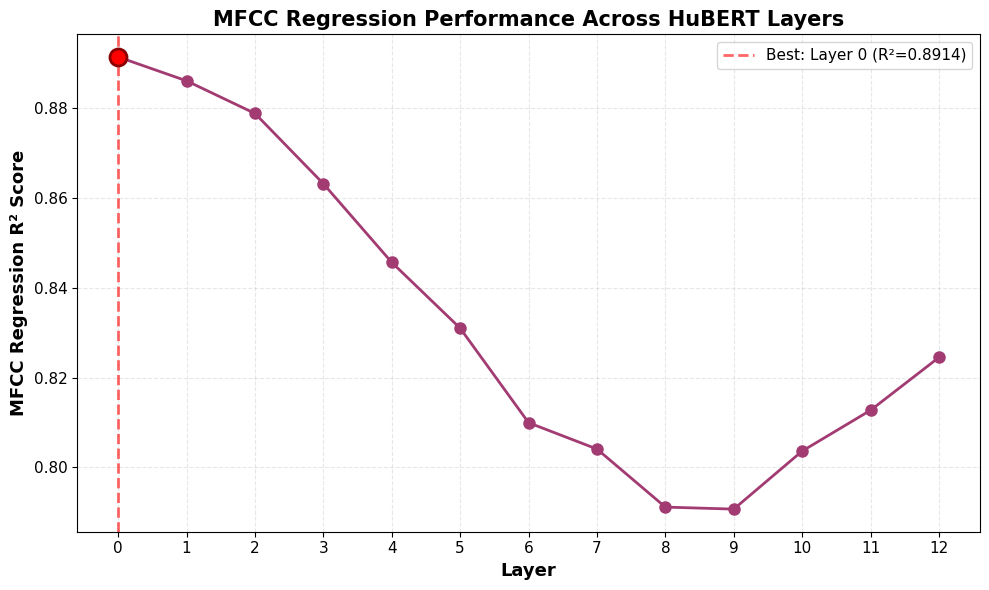

In [16]:
### Task 2 : Example code for training MFCC probes
## This code represents an example how the probes are trained.
## You can use this as a reference to train your probes, plot the results.
## You don't have to follow this exact code. Please feel free to modify as per your prior implementations.
### Task 2 : Training MFCC probes and plotting results

# Train MFCC probes for all layers
base_folder = "/content/drive/MyDrive/183/mfcc_dataset/mfcc_layer_datasets"
num_epochs = 5
batch_size = 512

# Store results for all layers
mfcc_all_results = []

print("Training MFCC probes for all layers (0-12)...")
print("=" * 60)

for layer_idx in range(13):
    print(f"\nTraining Layer {layer_idx}...")
    test_r2 = train_mfcc_probe(base_folder, layer_idx, num_epochs, batch_size)
    mfcc_all_results.append({'layer': layer_idx, 'overall_r2': test_r2})

print(f"\n{'='*60}")
print("TRAINING COMPLETED FOR ALL LAYERS")
print(f"{'='*60}")

# Print test R² for each layer
print("\nTest R² by Layer:")
print("-" * 30)
for result in mfcc_all_results:
    layer = result['layer']
    test_r2 = result['overall_r2']
    print(f"Layer {layer:2d}: {test_r2:.4f}")

best_result = max(mfcc_all_results, key=lambda x: x['overall_r2'])
print(f"\nBest performing layer: {best_result['layer']}")
print(f"Best test R²: {best_result['overall_r2']:.4f}")

# Create the plot
plt.figure(figsize=(10, 6))
layers = [result['layer'] for result in mfcc_all_results]
r2_scores = [result['overall_r2'] for result in mfcc_all_results]

plt.plot(layers, r2_scores, marker='o', linewidth=2, markersize=8, color='#A23B72')
plt.xlabel('Layer', fontsize=13, fontweight='bold')
plt.ylabel('MFCC Regression R² Score', fontsize=13, fontweight='bold')
plt.title('MFCC Regression Performance Across HuBERT Layers', fontsize=15, fontweight='bold')
plt.grid(True, alpha=0.3, linestyle='--')
plt.xticks(layers, fontsize=11)
plt.yticks(fontsize=11)

# Highlight best layer
best_layer = best_result['layer']
best_r2 = best_result['overall_r2']
plt.axvline(x=best_layer, color='red', linestyle='--', alpha=0.6, linewidth=2,
            label=f'Best: Layer {best_layer} (R²={best_r2:.4f})')
plt.scatter([best_layer], [best_r2], color='red', s=150, zorder=5, edgecolors='darkred', linewidth=2)

plt.legend(fontsize=11, loc='best')
plt.tight_layout()
plt.savefig('mfcc_r2_by_layer.png', dpi=300, bbox_inches='tight')
plt.show()

### Task 2: Deliverables

1. Plot of MFCC regression R^2 metric on y-axis vs layers (5 points)

2. Answer the following questions:

    2.1 What layer features does best MFCC regression task? (1 point)

    2.2 What does layer 0 represent in the Hubert model? (1 point)

    2.3 What does this plot show about how acoustic information is captured by Hubert? Why do you think that's the case? (3 points)


### Task 3: Speaker Embedding Analysis [10 points]

**Objective**: Analyze how well Hubert features capture **speaker identity** using t-SNE visualization.

Speaker embedding analysis investigates how well neural network representations capture speaker-specific information. Unlike phonetic or acoustic features that focus on linguistic content, speaker embeddings capture the unique characteristics that distinguish one speaker from another, such as:

- **Voice characteristics**: Fundamental frequency (F0), vocal tract length, speaking rate
- **Speaking style**: Prosody, rhythm, intonation patterns  
- **Physiological features**: Age, gender, accent, regional variations
- **Behavioral patterns**: Individual speaking habits and preferences

**Task Overview**: In this task, you will implement a **speaker embedding analysis** to understand how speaker identity information is encoded across different layers of the Hubert model. You will extract audio features from 20 speakers and compute mean-pooled Hubert features from for each layer, and use t-SNE dimensionality reduction to visualize how well different layers separate speakers in the feature space. Your goal is to investigate whether different layers of the model contain varying amounts of speaker information, and if so, how this information is distributed across the model's depth. You'll analyze t-SNE plots for all 13 layers to understand how Hubert's internal representations evolve from speaker-agnostic to speaker-specific information. This experiment will help you understand how Hubert balances linguistic content with speaker identity across its layers.


**download speaker embedding data from here**
https://drive.google.com/file/d/1L7r1c6_CIPVxNIQVPfrhD_Wt1MKCypU1/view?usp=sharing

In [19]:
data_zip = '/content/drive/MyDrive/183/lsmini-20speakers-50recordings.zip'

with zipfile.ZipFile(data_zip, 'r') as zip_ref:
    zip_ref.extractall('/content/drive/MyDrive/183')

print("extracted")
speaker_base_folder = "/content/drive/MyDrive/183/mfcc_dataset"

extracted


In [20]:
# Import additional libraries for speaker embedding analysis
from transformers import HubertModel, Wav2Vec2FeatureExtractor
import torchaudio
from sklearn.manifold import TSNE
import seaborn as sns

In [21]:

def load_hubert_model():
    """
    Load the Hubert model and feature extractor.
    """
    print("Loading Hubert model...")
    model = HubertModel.from_pretrained("facebook/hubert-base-ls960")
    feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("facebook/hubert-base-ls960")
    return model, feature_extractor

def extract_speaker_embedding(audio_path, model, feature_extractor, layer_idx=0):
    """
    Extract Hubert features from a specific layer.

    Args:
        audio_path (str): Path to audio file
        model: Hubert model
        feature_extractor: Hubert feature extractor
        layer_idx (int): Layer index (0-12, where 0 is embedding layer)

    Returns:
        torch.Tensor: Features from the specified layer
    """
    # Load and preprocess audio using torchaudio
    audio, sr = torchaudio.load(audio_path)

    if audio.shape[0] > 1:
        audio = torch.mean(audio, dim=0, keepdim=True)

    # Resample to 16kHz if needed. Hubert model expects 16kHz audio.
    if sr != 16000:
        resampler = torchaudio.transforms.Resample(sr, 16000)
        audio = resampler(audio)

    audio = audio.squeeze()

    # Extract features using feature extractor
    inputs = feature_extractor(audio, sampling_rate=16000, return_tensors="pt")

    # Move to same device as model
    device = next(model.parameters()).device
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Extract features from the specified layer
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)
        hidden_states = outputs.hidden_states[layer_idx] # Index 0 is the embedding layer, indices 1-12 are transformer layers

    # TODO : Make sure to do mean-pooling across the time dimension.
    ## The speaker embedding from each layer is the mean-pooled features across the time dimension.
    speaker_embedding = torch.mean(hidden_states, dim=1).squeeze()

    return speaker_embedding

In [ ]:
# TODO : Go through the dataset and extract the speaker embeddings for each layer.
# Audio files are present as 307-127535-0000.flac. The speaker id is 307. All audio files with the same speaker id are from the same speaker.
# Each speaker should have 50 audios per speaker. You will thus extract 50 embeddings per speaker for each layer. Do this for all 20 speakers.

# TODO : Use t-SNE to visualize the speaker embeddings. We want to see clusters of the embeddings by speaker id.

# TODO : Plot the t-SNE plot for all 13 layers separately.

Loading Hubert model...
Found 1000 audio files
Found 20 unique speakers: ['1355', '1447', '1594', '1898', '2136', '2514', '2691', '2911', '307', '332', '3830', '403', '405', '4680', '5514', '6147', '7511', '7800', '8238', '8425']

Extracting embeddings for Layer 0


Layer 0: 100%|██████████| 1000/1000 [01:21<00:00, 12.25it/s]


Extracted 1000 embeddings of shape (768,)

Extracting embeddings for Layer 1


Layer 1: 100%|██████████| 1000/1000 [01:12<00:00, 13.84it/s]


Extracted 1000 embeddings of shape (768,)

Extracting embeddings for Layer 2


Layer 2: 100%|██████████| 1000/1000 [01:11<00:00, 13.91it/s]


Extracted 1000 embeddings of shape (768,)

Extracting embeddings for Layer 3


Layer 3: 100%|██████████| 1000/1000 [01:13<00:00, 13.54it/s]


Extracted 1000 embeddings of shape (768,)

Extracting embeddings for Layer 4


Layer 4: 100%|██████████| 1000/1000 [01:12<00:00, 13.70it/s]


Extracted 1000 embeddings of shape (768,)

Extracting embeddings for Layer 5


Layer 5: 100%|██████████| 1000/1000 [01:13<00:00, 13.70it/s]


Extracted 1000 embeddings of shape (768,)

Extracting embeddings for Layer 6


Layer 6: 100%|██████████| 1000/1000 [01:12<00:00, 13.72it/s]


Extracted 1000 embeddings of shape (768,)

Extracting embeddings for Layer 7


Layer 7: 100%|██████████| 1000/1000 [01:13<00:00, 13.69it/s]


Extracted 1000 embeddings of shape (768,)

Extracting embeddings for Layer 8


Layer 8: 100%|██████████| 1000/1000 [01:12<00:00, 13.72it/s]


Extracted 1000 embeddings of shape (768,)

Extracting embeddings for Layer 9


Layer 9: 100%|██████████| 1000/1000 [01:12<00:00, 13.71it/s]


Extracted 1000 embeddings of shape (768,)

Extracting embeddings for Layer 10


Layer 10: 100%|██████████| 1000/1000 [01:12<00:00, 13.71it/s]


Extracted 1000 embeddings of shape (768,)

Extracting embeddings for Layer 11


Layer 11: 100%|██████████| 1000/1000 [01:13<00:00, 13.69it/s]


Extracted 1000 embeddings of shape (768,)

Extracting embeddings for Layer 12


Layer 12: 100%|██████████| 1000/1000 [01:12<00:00, 13.71it/s]


Extracted 1000 embeddings of shape (768,)

Embedding extraction complete!
Creating t-SNE plot for Layer 0...
Creating t-SNE plot for Layer 1...
Creating t-SNE plot for Layer 2...
Creating t-SNE plot for Layer 3...
Creating t-SNE plot for Layer 4...
Creating t-SNE plot for Layer 5...
Creating t-SNE plot for Layer 6...
Creating t-SNE plot for Layer 7...
Creating t-SNE plot for Layer 8...
Creating t-SNE plot for Layer 9...
Creating t-SNE plot for Layer 10...
Creating t-SNE plot for Layer 11...
Creating t-SNE plot for Layer 12...


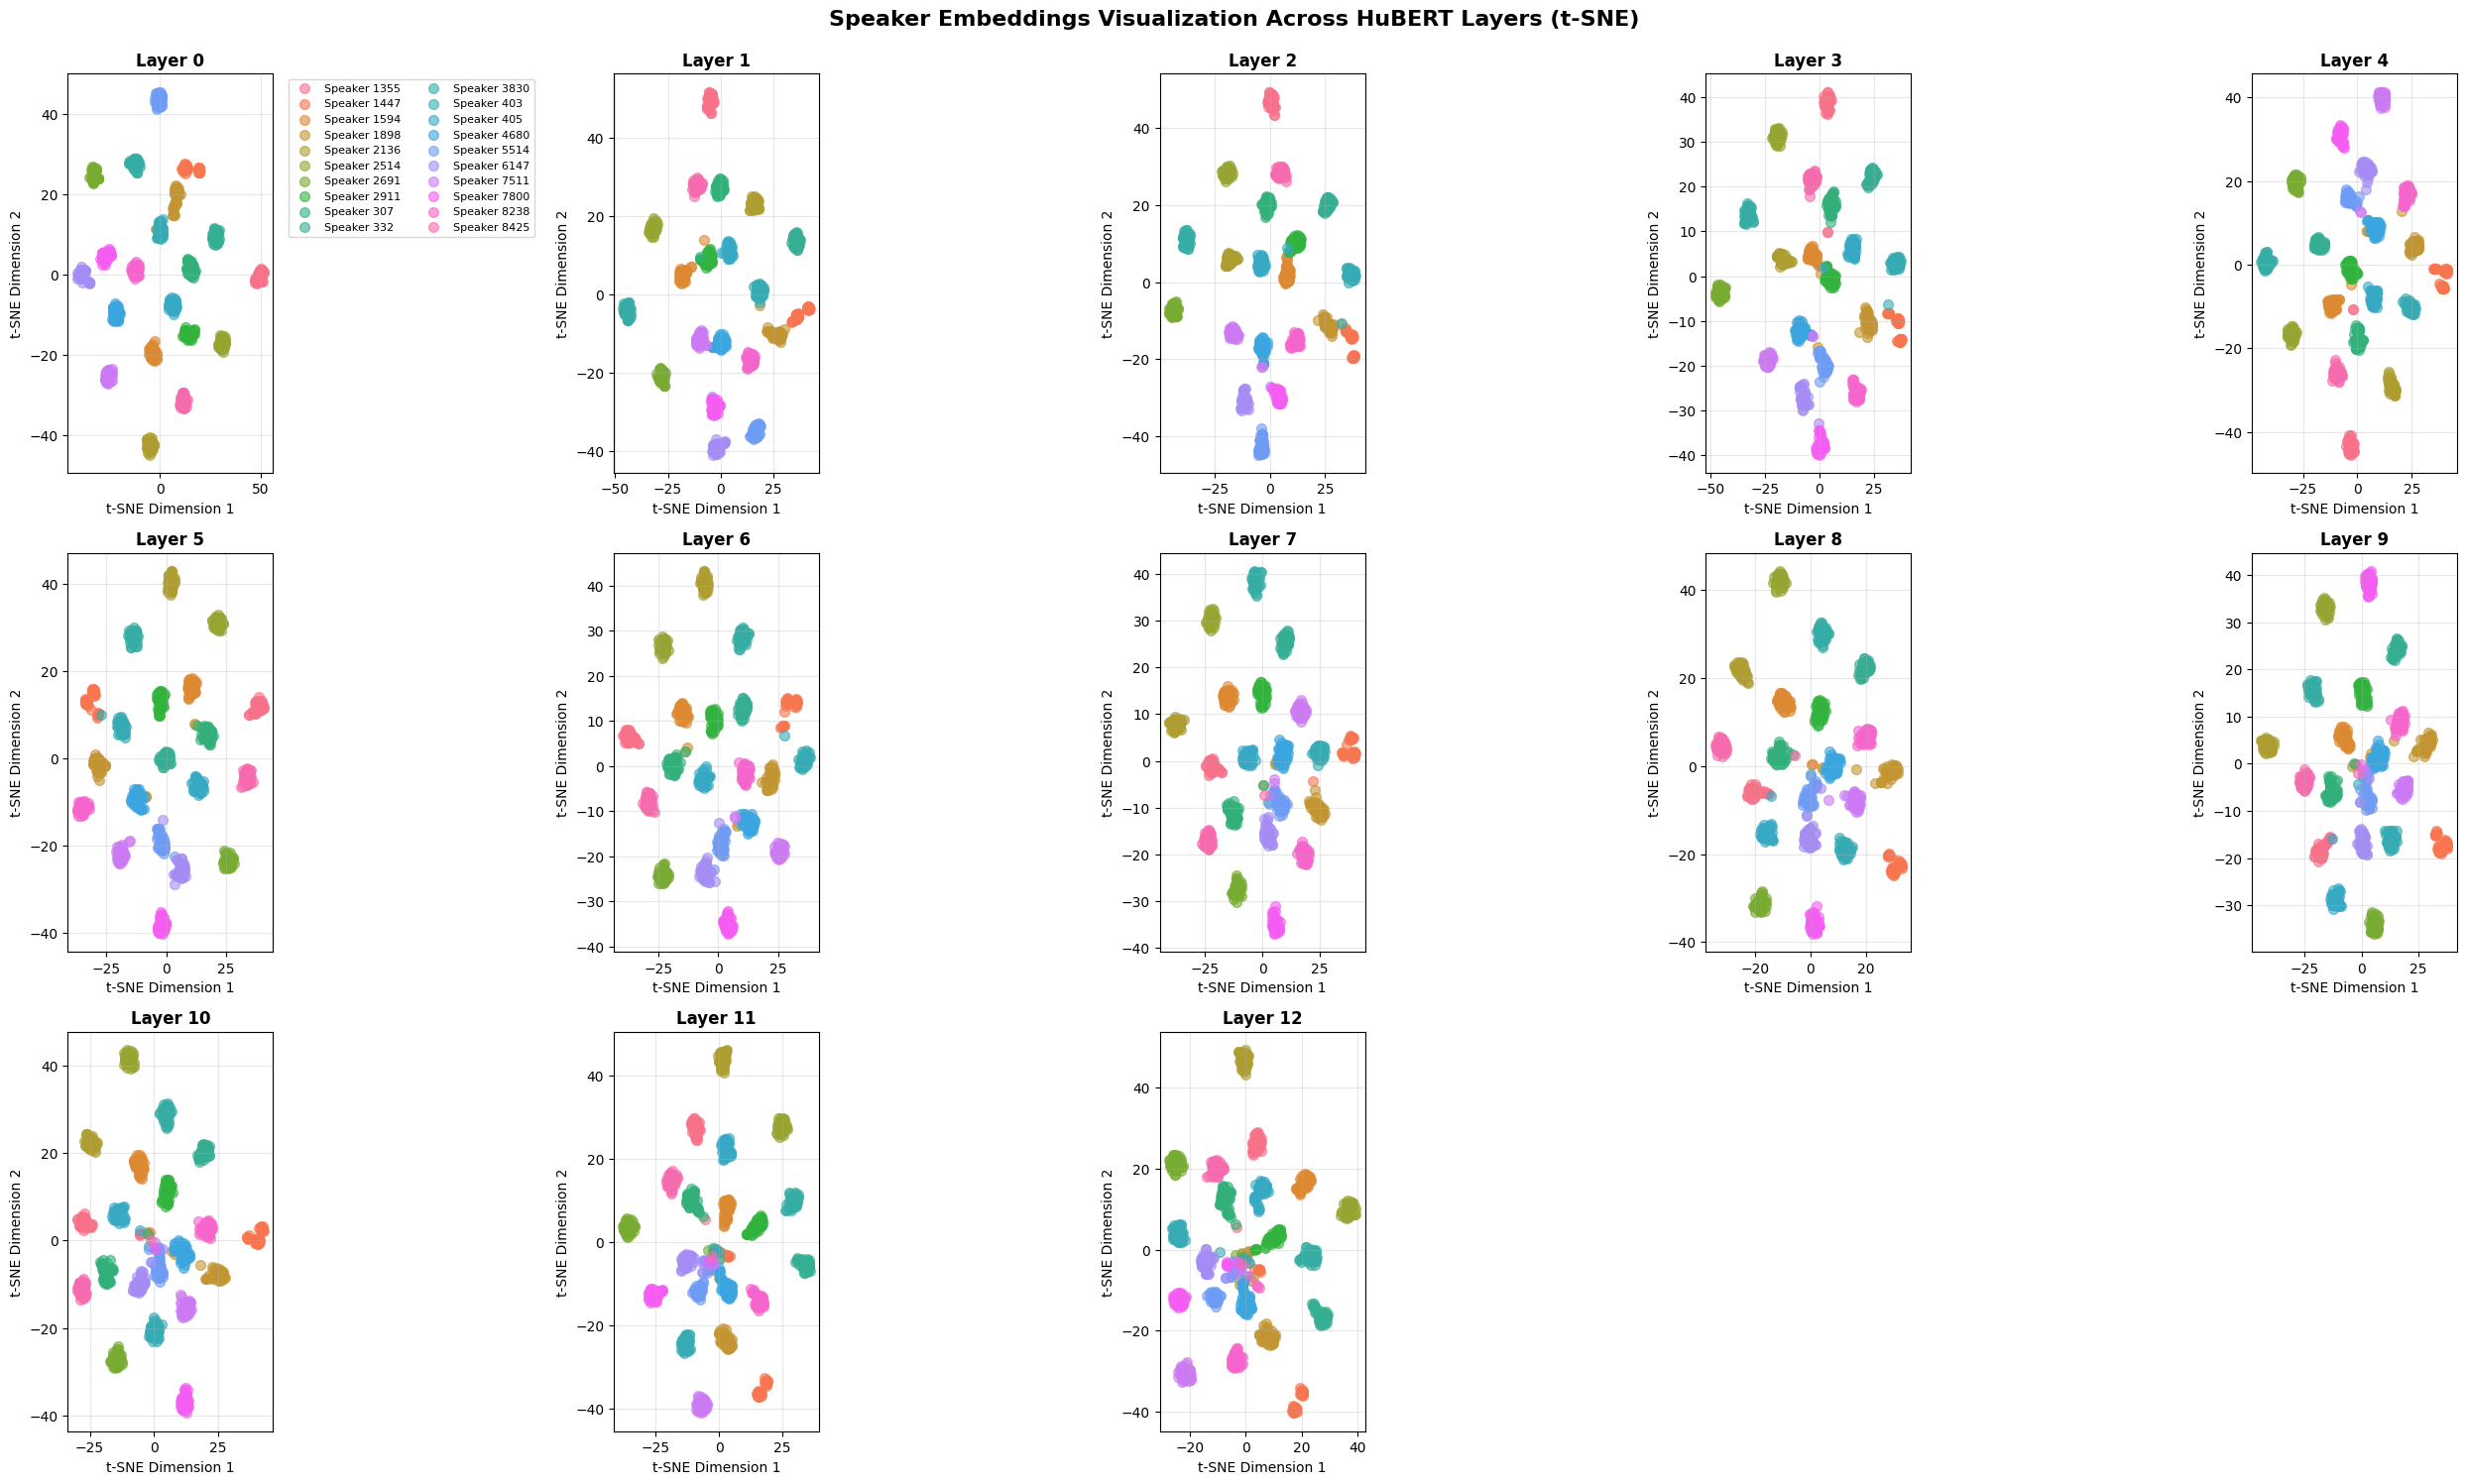


Plot saved as 'speaker_embeddings_tsne_all_layers.png'

Speaker Embedding Statistics
Speaker 1355: 50 audio files
Speaker 1447: 50 audio files
Speaker 1594: 50 audio files
Speaker 1898: 50 audio files
Speaker 2136: 50 audio files
Speaker 2514: 50 audio files
Speaker 2691: 50 audio files
Speaker 2911: 50 audio files
Speaker 307: 50 audio files
Speaker 332: 50 audio files
Speaker 3830: 50 audio files
Speaker 403: 50 audio files
Speaker 405: 50 audio files
Speaker 4680: 50 audio files
Speaker 5514: 50 audio files
Speaker 6147: 50 audio files
Speaker 7511: 50 audio files
Speaker 7800: 50 audio files
Speaker 8238: 50 audio files
Speaker 8425: 50 audio files


In [23]:
import os
import glob
from tqdm import tqdm
import numpy as np

# Load model
model, feature_extractor = load_hubert_model()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.eval()

# Path to audio files
audio_folder = "/content/drive/MyDrive/183/lsmini-20speakers-50recordings"

# Get all audio files and extract speaker IDs
audio_files = sorted(glob.glob(os.path.join(audio_folder, "*.flac")))
print(f"Found {len(audio_files)} audio files")

# Extract speaker IDs from filenames (format: 307-127535-0000.flac)
speaker_ids = []
for audio_file in audio_files:
    filename = os.path.basename(audio_file)
    speaker_id = filename.split('-')[0]
    speaker_ids.append(speaker_id)

unique_speakers = sorted(list(set(speaker_ids)))
print(f"Found {len(unique_speakers)} unique speakers: {unique_speakers}")

# Extract embeddings for all layers
all_layer_embeddings = {}  # layer_idx -> list of embeddings
all_layer_speaker_labels = {}  # layer_idx -> list of speaker IDs

for layer_idx in range(13):
    print(f"\n{'='*60}")
    print(f"Extracting embeddings for Layer {layer_idx}")
    print(f"{'='*60}")

    embeddings = []
    labels = []

    for audio_file, speaker_id in tqdm(zip(audio_files, speaker_ids), total=len(audio_files), desc=f"Layer {layer_idx}"):
        try:
            embedding = extract_speaker_embedding(audio_file, model, feature_extractor, layer_idx)
            embeddings.append(embedding.cpu().numpy())
            labels.append(speaker_id)
        except Exception as e:
            print(f"Error processing {audio_file}: {e}")
            continue

    all_layer_embeddings[layer_idx] = np.array(embeddings)
    all_layer_speaker_labels[layer_idx] = labels

    print(f"Extracted {len(embeddings)} embeddings of shape {embeddings[0].shape}")

print("\n" + "="*60)
print("Embedding extraction complete!")
print("="*60)

# Create t-SNE visualizations for all layers
fig, axes = plt.subplots(3, 5, figsize=(25, 15))
axes = axes.flatten()

for layer_idx in range(13):
    print(f"Creating t-SNE plot for Layer {layer_idx}...")

    embeddings = all_layer_embeddings[layer_idx]
    labels = all_layer_speaker_labels[layer_idx]

    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
    embeddings_2d = tsne.fit_transform(embeddings)

    # Create color map for speakers
    unique_labels = sorted(list(set(labels)))
    colors = sns.color_palette("husl", len(unique_labels))
    color_map = {label: colors[i] for i, label in enumerate(unique_labels)}

    # Plot
    ax = axes[layer_idx]
    for speaker_id in unique_labels:
        mask = [l == speaker_id for l in labels]
        ax.scatter(embeddings_2d[mask, 0], embeddings_2d[mask, 1],
                  label=f'Speaker {speaker_id}',
                  alpha=0.6,
                  s=50,
                  color=color_map[speaker_id])

    ax.set_title(f'Layer {layer_idx}', fontsize=12, fontweight='bold')
    ax.set_xlabel('t-SNE Dimension 1', fontsize=10)
    ax.set_ylabel('t-SNE Dimension 2', fontsize=10)
    ax.grid(True, alpha=0.3)

    # Add legend only for first plot
    if layer_idx == 0:
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8, ncol=2)

# Hide extra subplots
for i in range(13, len(axes)):
    axes[i].set_visible(False)

plt.suptitle('Speaker Embeddings Visualization Across HuBERT Layers (t-SNE)',
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('speaker_embeddings_tsne_all_layers.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nPlot saved as 'speaker_embeddings_tsne_all_layers.png'")

# Print statistics about speaker clustering
print("\n" + "="*60)
print("Speaker Embedding Statistics")
print("="*60)
for speaker_id in unique_labels:
    count = labels.count(speaker_id)
    print(f"Speaker {speaker_id}: {count} audio files")

### Task 3: Deliverables

1. Plot the speaker embedding t-SNE plots for each layer. There should be 13 plots. Each plot should have 20 clusters, 1 per speaker, with 50 speaker embeddings per speaker. (5 points)

2. Answer the following questions:

    2.1 Do speaker embeddings form neat clusters or mix together? (1 point)

    2.2 What does this plot show about how speaker information is captured by Hubert? Answer this question based on how the plots evolve as we go deeper into the model. (4 points)


### Bonus: Make your own Speaker Embedding Cluster (10 points)

1. Record 5 **different** sentences in your own voice in each of the following settings:

   1.1 Use two different mics (For example laptop and phone or something else)

   1.2 For each mic, record yourself in 3 different enviornments (eg: home, campus, bus, or whever else you are comfortable using your mics). Make sure to use the same 3 environments with both mics.
   
   1.3 You should have 2 * 3 * 5 = 30 recordings, divided into 6 groups of 5 recordings.
2. Create speaker embeddings for audio files using the mean pooling code for each group.
3. Create your own speaker embedding cluster and add it to one of the plots above with the other speakers in the dataset. You can choose the layer of your choice. Note that you should add 6 additional groups in the existing clusters. This graph is the final deliverable (6 points).

Answer the following questions:
1. What do you observe about how the 6 groups are placed with respect to the clusters of the other speakers? Explain why. (2 points)
2. What do you observe about how the 6 groups are arranged amongst each other? Explain why. (2 points)